In [1]:
from pvlib import spectrum, solarposition, irradiance, atmosphere
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pyradi.ryplot as ryplot
import os, sys
import datetime
import math

# from datetime import datetime, timedelta

import julian


In [2]:
print(julian.to_jd(datetime.datetime(2010, 1, 21) + datetime.timedelta(hours=3, minutes=15), fmt='jd'))
print(julian.to_jd(datetime.datetime(2010, 1, 21), fmt='jd'))


2455217.6354166665
2455217.5


In [3]:


def get_julian_datetime(date):
    """
    Convert a datetime object into julian float.
    Args:
        date: datetime-object of date in question

    Returns: float - Julian calculated datetime.
    Raises: 
        TypeError : Incorrect parameter type
        ValueError: Date out of range of equation
    """

    # Ensure correct format
    if not isinstance(date, datetime.datetime):
        raise TypeError('Invalid type for parameter "date" - expecting datetime')
    elif date.year < 1801 or date.year > 2099:
        raise ValueError('Datetime must be between year 1801 and 2099')

    # Perform the calculation
    julian_datetime = 367 * date.year - int((7 * (date.year + int((date.month + 9) / 12.0))) / 4.0) + int(
        (275 * date.month) / 9.0) + date.day + 1721013.5 + (
                          date.hour + date.minute / 60.0 + date.second / math.pow(60,
                                                                                  2)) / 24.0 - 0.5 * math.copysign(
        1, 100 * date.year + date.month - 190002.5) + 0.5

    return julian_datetime

## Demo example 

https://pvlib-python.readthedocs.io/en/stable/auto_examples/plot_spectrl2_fig51A.html#sphx-glr-auto-examples-plot-spectrl2-fig51a-py


In [4]:

# assumptions from the technical report:
lat = 37
lon = -100
tilt = 37
azimuth = 180
pressure = 101300  # sea level, roughly
water_vapor_content = 0.5  # cm
tau500 = 0.1
ozone = 0.31  # atm-cm
albedo = 0.2

times = pd.date_range('1984-03-20 06:17', freq='h', periods=6, tz='Etc/GMT+7')
solpos = solarposition.get_solarposition(times, lat, lon)
aoi = irradiance.aoi(tilt, azimuth, solpos.apparent_zenith, solpos.azimuth)

# The technical report uses the 'kasten1966' airmass model, but later
# versions of SPECTRL2 use 'kastenyoung1989'.  Here we use 'kasten1966'
# for consistency with the technical report.
relative_airmass = atmosphere.get_relative_airmass(solpos.apparent_zenith,
                                                   model='kasten1966')


In [5]:
spectra = spectrum.spectrl2(
    apparent_zenith=solpos.apparent_zenith,
    aoi=aoi,
    surface_tilt=tilt,
    ground_albedo=albedo,
    surface_pressure=pressure,
    relative_airmass=relative_airmass,
    precipitable_water=water_vapor_content,
    ozone=ozone,
    aerosol_turbidity_500nm=tau500,
)

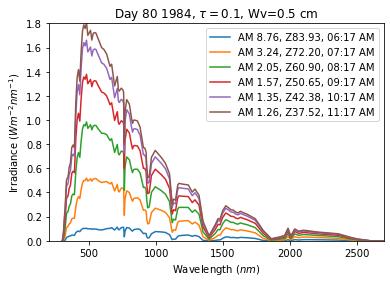

In [6]:
plt.figure()
plt.plot(spectra['wavelength'], spectra['poa_global'])
plt.xlim(200, 2700)
plt.ylim(0, 1.8)
plt.title(r"Day 80 1984, $\tau=0.1$, Wv=0.5 cm")
plt.ylabel(r"Irradiance ($W m^{-2} nm^{-1}$)")
plt.xlabel(r"Wavelength ($nm$)")
time_labels = times.strftime("%H:%M %p")
labels = [
    "AM {:0.02f}, Z{:0.02f}, {}".format(*vals)
    for vals in zip(relative_airmass, solpos.apparent_zenith, time_labels)
]
plt.legend(labels)
plt.show()

<AxesSubplot:>

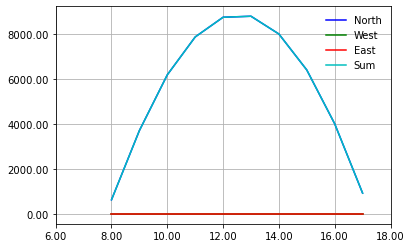

In [27]:

def irradprofile(lat,lon,tilt,azimuth,times,pressure = 101300,water_vapor_content = 0.5,tau500 = 0.1,ozone = 0.31 ,albedo = 0.2):

    
    solpos = solarposition.get_solarposition(times, lat, lon)
    aoi = irradiance.aoi(tilt, azimuth, solpos.apparent_zenith, solpos.azimuth)

    # The technical report uses the 'kasten1966' airmass model, but later
    # versions of SPECTRL2 use 'kastenyoung1989'.  Here we use 'kasten1966'
    # for consistency with the technical report.
    relative_airmass = atmosphere.get_relative_airmass(solpos.apparent_zenith,
                                                       model='kasten1966')
    spectra = spectrum.spectrl2(
        apparent_zenith=solpos.apparent_zenith,
        aoi=aoi,
        surface_tilt=tilt,
        ground_albedo=albedo,
        surface_pressure=pressure,
        relative_airmass=relative_airmass,
        precipitable_water=water_vapor_content,
        ozone=ozone,
        aerosol_turbidity_500nm=tau500,
    )

    wls = spectra['wavelength'][20:40]
    spectra = np.asarray(spectra['poa_global'])[20:40,:]
    irrad = np.trapz(spectra,wls,axis=0)
    irrad = np.where(irrad<0,0,irrad)
    return irrad

Neast = 0
Nwest = 0
Nnorth = 44
QE = 0.6

ptimes = pd.date_range('2022-06-21 00:00', freq='h', periods=25, tz='Etc/GMT-2')
fluxN = QE * Nnorth * irradprofile(lat=-34.081,lon=22.159,tilt=30,azimuth=0,times=ptimes).astype(object)
fluxO = QE * Neast * irradprofile(lat=-34.081,lon=22.159,tilt=30,azimuth=90,times=ptimes).astype(object)
fluxW = QE * Nwest * irradprofile(lat=-34.081,lon=22.159,tilt=30,azimuth=-90,times=ptimes).astype(object)

flux = fluxN + fluxO + fluxW

times = []
for t in ptimes:
    times.append(julian.to_jd(t.to_pydatetime(), fmt='jd'))
times = 24*np.asarray(times)
times -= times[0]

p = ryplot.Plotter(1,1,1,figsize=(6,4))
p.plot(1,times,fluxN,label=['North'])
p.plot(1,times,fluxW,label=['West'])
p.plot(1,times,fluxO,label=['East'])
p.plot(1,times,flux,label=['Sum'])


<AxesSubplot:>

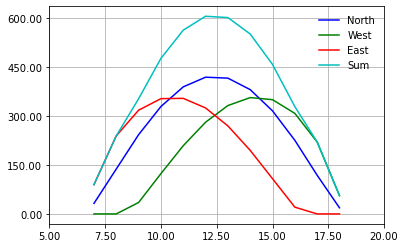

AttributeError: 'numpy.ndarray' object has no attribute 'strftime'

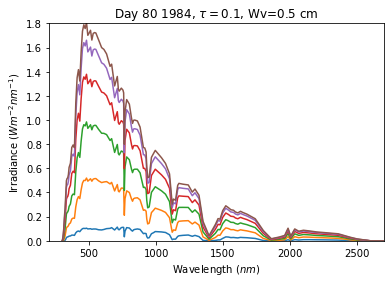

In [9]:
plt.figure()
plt.plot(spectra['wavelength'], spectra['poa_global'])
plt.xlim(200, 2700)
plt.ylim(0, 1.8)
plt.title(r"Day 80 1984, $\tau=0.1$, Wv=0.5 cm")
plt.ylabel(r"Irradiance ($W m^{-2} nm^{-1}$)")
plt.xlabel(r"Wavelength ($nm$)")
time_labels = times.strftime("%H:%M %p")
labels = [
    "AM {:0.02f}, Z{:0.02f}, {}".format(*vals)
    for vals in zip(relative_airmass, solpos.apparent_zenith, time_labels)
]
plt.legend(labels)
plt.show()